In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

In [2]:
train = pd.read_csv('./files/train.csv', header=0)
test = pd.read_csv('./files/test.csv', header=0)

In [4]:
print(train.shape)
print(test.shape)

(490513, 10)
(518376, 8)


In [9]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [6]:
test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


Описание данных:
* PERIOD - месяц транзакции
* cl_id - id клиента
* MCC - код продавца
* channel_type - канал привлечения клиента
* currency - валюта
* TRDATETIME - дата/время транзакции
* amount - сумма транзакции
* trx_category - вид транзакции, POS – оплата через POS терминал, C2C_OUT – перевод на карту (исходящий платёж), C2C_IN – перевод на карту (входящий платёж), DEPOSIT – пополнение карты в банкомате, WD_ATM_PARTNER – снятие наличных в банкоматах партнерах,
* target_flag - продолжит ли клиент пользоваться продуктом после льготного периода (1/0) (target)
* target_sum - сумма транзакций вида POS за три будущих месяца (target)

# Визуальный анализ

#### PERIOD

In [10]:
train['PERIOD'] = pd.to_datetime(train['PERIOD'], format='%d/%m/%Y')
test['PERIOD'] = pd.to_datetime(test['PERIOD'], format='%d/%m/%Y')

In [19]:
train['month'] = train['PERIOD'].dt.month
test['month'] = test['PERIOD'].dt.month

train['year'] = train['PERIOD'].dt.year
test['year'] = test['PERIOD'].dt.year

In [22]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,month,year
0,2017-10-01,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0,10,2017
1,2017-10-01,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,10,2017
2,2017-12-01,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0,12,2017
3,2017-10-01,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0,10,2017
4,2017-10-01,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,10,2017


Найдем "минимальную" и "максимальную" дату.

In [35]:
"Min date train: ", print(train['PERIOD'].min())
"Min date test: ", print(test['PERIOD'].min())

"Max date train: ", print(train['PERIOD'].max())
"Max date test: ", print(test['PERIOD'].max())

2016-10-01 00:00:00
2016-10-01 00:00:00
2018-04-01 00:00:00
2018-04-01 00:00:00


('Max date test: ', None)

In [28]:
print(train['year'].value_counts());
print(test['year'].value_counts());

2017    411734
2016     70405
2018      8374
Name: year, dtype: int64
2017    431779
2016     77754
2018      8843
Name: year, dtype: int64


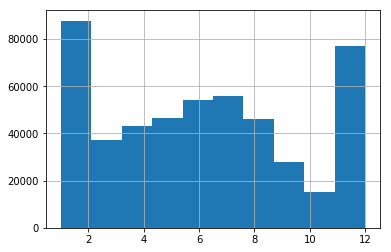

In [30]:
train['month'].hist();

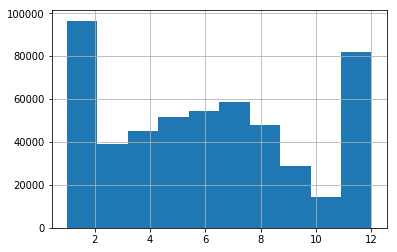

In [31]:
test['month'].hist();

Некоторые *выводы*:
1. Данные в обучающей и тестовой выборке за одинаковые периоды.
2. Можно делать "помесячные признаки": количество транзакций в определнном месяце, сумма потраченная в определенном месяце, категории, распределенные по месяцам, валюты по месяцам и т.д.
3. Год тоже влияет. Лучше будет сделать признаки с 10-2016 по 04-2018 (19 месяцев)

#### cl_id

cl_id - айдишник клиента. 

In [38]:
print(train['cl_id'].nunique())
print(test['cl_id'].nunique())

5000
5217


In [51]:
print(train['cl_id'].value_counts().describe())
print(test['cl_id'].value_counts().describe())


count    5000.000000
mean       98.102600
std        78.107609
min         1.000000
25%        34.000000
50%        83.000000
75%       145.000000
max       784.000000
Name: cl_id, dtype: float64
count    5217.000000
mean       99.362852
std        79.001444
min         1.000000
25%        34.000000
50%        85.000000
75%       146.000000
max       555.000000
Name: cl_id, dtype: float64


Выводы:
1. Фичи нужно будет считать для кадого отдельного id-ка (получается, в обучающей выборке будет 5000 примеров, в тестовой 5217)
2. По этому признаку можно будет посчитать количество транзакций (всего) + по месяцам.

#### MCC

MCC - код продавца.
Справочник кодов http://www.banki.ru/wikibank/mcc-kod/

In [58]:
print(train['MCC'].nunique())
print(test['MCC'].nunique())

'Intersection train and test: ', len(set(train['MCC']).intersection(set(test['MCC'])))

344
344


('Intersection train and test: ', 304)

*Вывод:*
40 категорий различаются в train и test. Нужно будет учесть.

In [60]:
print(train['MCC'].value_counts().head())
print(test['MCC'].value_counts().head())

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
Name: MCC, dtype: int64
5411    129455
6011     55341
5814     43407
5812     32543
5499     29237
Name: MCC, dtype: int64


- 5411 - супермаркеты
- 6011 - банкомат
- 5814 - фастфуд
- 5812 - рестораны
- 5499 - продовольственные магазины

*Выводы:*
1. Здесь можно сделать "помесячные" фичи. Типо количсетво посещений топовых категорий (например, топ_20).
2. Также можно собрать какие-то статистические фичи: количество разных категорий, попадание в какой-то топ, попадание в непопулярные категории.


#### channel_type

channel_type - канал привлечения клиента.

In [63]:
print(train['channel_type'].isnull().sum())
print(test['channel_type'].isnull().sum())

2910
2154


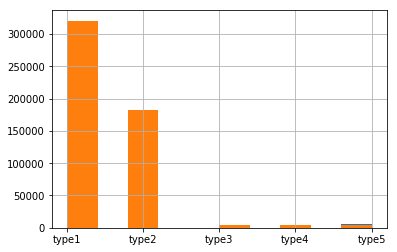

In [68]:
train['channel_type'].hist()

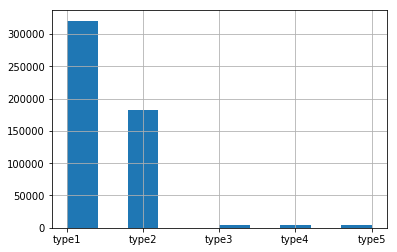

In [69]:
test['channel_type'].hist()

Проверим, бывают ли разные значения channel_type для одного cl_id.